# Example EDA of toxicity annotation dataset

## Step 1: Download datasets

In [350]:
import urllib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [351]:
def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

In [ ]:
TOXICITY_ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7394542' 
TOXICITY_ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7394539'
TOXICITY_WORKER_DEMOGRAPHICS_IRL = 'https://ndownloader.figshare.com/files/7640581'

download_file(TOXICITY_ANNOTATED_COMMENTS_URL, 'data/toxicity_annotated_comments.tsv')
download_file(TOXICITY_ANNOTATIONS_URL, 'data/toxicity_annotations.tsv')
download_file(TOXICITY_WORKER_DEMOGRAPHICS_IRL, 'data/toxicity_worker_demographics.tsv')

In [ ]:
ATTACK_ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ATTACK_ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637'
ATTACK_WORKER_DEMOGRAPHICS_IRL = 'https://ndownloader.figshare.com/files/7640752'

download_file(ATTACK_ANNOTATED_COMMENTS_URL, 'data/attack_annotated_comments.tsv')
download_file(ATTACK_ANNOTATIONS_URL, 'data/attack_annotations.tsv')
download_file(ATTACK_WORKER_DEMOGRAPHICS_IRL, 'data/attack_worker_demographics.tsv')

## Step 2: Load tables using pandas

In [353]:
toxicity_annotations = pd.read_csv("data/toxicity_annotations.tsv", delimiter="\t")
toxicity_annotated_comments = pd.read_csv("data/toxicity_annotated_comments.tsv", delimiter="\t")
toxicity_worker_demographics = pd.read_csv("data/toxicity_worker_demographics.tsv", delimiter="\t")

toxicity_worker_demographics = toxicity_worker_demographics.set_index("worker_id")

In [354]:
attack_annotations = pd.read_csv("data/attack_annotations.tsv", delimiter="\t")
attack_annotated_comments = pd.read_csv("data/attack_annotated_comments.tsv", delimiter="\t")
attack_worker_demographics = pd.read_csv("data/attack_worker_demographics.tsv", delimiter="\t")

attack_worker_demographics = attack_worker_demographics.set_index("worker_id")

In [356]:
toxicity_annotations = pd.read_csv("data/toxicity_annotations.tsv", delimiter="\t")
toxicity_annotated_comments = pd.read_csv("data/toxicity_annotated_comments.tsv", delimiter="\t")
toxicity_worker_demographics = pd.read_csv("data/toxicity_worker_demographics.tsv", delimiter="\t")

toxicity_worker_demographics = toxicity_worker_demographics.set_index("worker_id")

Briefly inspect each table.

In [357]:
toxicity_annotations.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [20]:
toxicity_annotated_comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [358]:
toxicity_worker_demographics.head()

,gender,english_first_language,age_group,education
worker_id,,,,
85,female,0,18-30,bachelors
1617,female,0,45-60,bachelors
1394,female,0,NaN,bachelors
311,male,0,30-45,bachelors
1980,male,0,45-60,masters


## Step 3: Join annotation table to demographics table

In [359]:
joined_annotations = pd.merge(toxicity_annotations, toxicity_worker_demographics, left_on="worker_id", right_index=True)

In [360]:
joined_annotations.head()

,rev_id,worker_id,toxicity,toxicity_score,gender,english_first_language,age_group,education
0,2232.0,723,0,0.0,female,0,30-45,bachelors
71,37346.0,723,0,0.0,female,0,30-45,bachelors
417,227181.0,723,0,0.0,female,0,30-45,bachelors
4281,2810755.0,723,0,0.0,female,0,30-45,bachelors
10305,7270696.0,723,0,0.0,female,0,30-45,bachelors


## Basic EDA

At this point you start asking question.

I can calculate the average score per worker - that worker's "toxicity bias". Is this different for different age groups?

In [361]:
mean_toxicity_score = joined_annotations.groupby("worker_id")["toxicity_score"].mean()
toxicity_worker_demographics["mean_toxicity_score"] = mean_toxicity_score

Take a quick look at our newly augmented table.

In [362]:
toxicity_worker_demographics.head()

,gender,english_first_language,age_group,education,mean_toxicity_score
worker_id,,,,,
85,female,0,18-30,bachelors,-0.131417
1617,female,0,45-60,bachelors,-0.080831
1394,female,0,NaN,bachelors,-0.185882
311,male,0,30-45,bachelors,-0.082789
1980,male,0,45-60,masters,0.582938


Now let's compute an average toxicity statistic for each group...

In [363]:
toxicity_worker_demographics.groupby("age_group").mean_toxicity_score.mean()

age_group
18-30       0.192189
30-45       0.236698
45-60       0.228319
Over 60     0.157787
Under 18    0.282304
Name: mean_toxicity_score, dtype: float64

The "toxicity bias" does vary by group!

We can even plot the distribution of personal biases in each group:

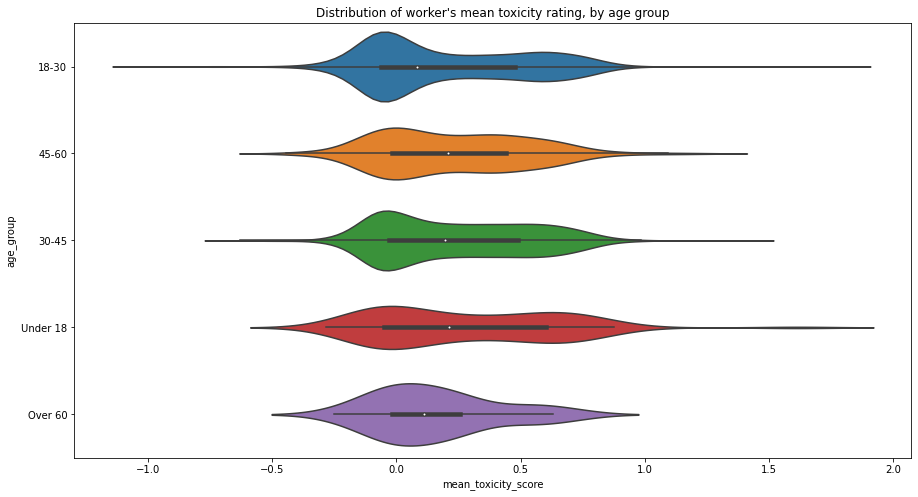

In [27]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of worker's mean toxicity rating, by age group")
sns.violinplot( x="mean_toxicity_score", y="age_group", data=toxicity_worker_demographics, ax=ax )

## A very basic bias question: is the set of annotation workers gender-balanced?

In [364]:
foo = toxicity_worker_demographics.groupby("gender").age_group.count()
foo/foo.sum()

gender
female    0.351167
male      0.648549
other     0.000285
Name: age_group, dtype: float64

The answer is **no** - 64.8% of annotators are male.

## Is the set of _annotations_ gender-balanced?

In [365]:
foo = joined_annotations.groupby("gender").rev_id.count()
foo/foo.sum()

gender
female    0.339541
male      0.660194
other     0.000266
Name: rev_id, dtype: float64

Also no, about the same fraction - 66.0% of annotations - were made by male annotators.

## Question 1: Analyze the level of disagreement among crowdworkers around certain labels

### Toxicity

In [366]:
toxicity_mean = toxicity_annotations.groupby("rev_id")["toxicity_score"].mean().to_frame().head().reset_index()

In [367]:
toxic_count = pd.DataFrame({"toxic_count": toxicity_annotations.groupby("rev_id")["toxicity"].apply(lambda c : c.sum())}).reset_index()

In [368]:
nontoxic_count = pd.DataFrame({"nontoxic_count": toxicity_annotations.groupby("rev_id")["toxicity"].apply(lambda c : (c == 0).sum())}).reset_index()

In [369]:
joined_toxicity_count = toxic_count.set_index("rev_id").join(nontoxic_count.set_index("rev_id")).reset_index()
joined_toxicity_count['total_count'] = joined_toxicity_count["toxic_count"] + joined_toxicity_count["nontoxic_count"]
joined_toxicity_count['p_toxic'] = joined_toxicity_count['toxic_count']/joined_toxicity_count['total_count']
joined_toxicity_count['p_nontoxic'] = joined_toxicity_count['nontoxic_count']/joined_toxicity_count['total_count']
joined_toxicity_count["entropy"] = -(np.log2(joined_toxicity_count['p_toxic'])*joined_toxicity_count['p_toxic']) - (np.log2(joined_toxicity_count['p_nontoxic'])*joined_toxicity_count['p_nontoxic'])
joined_toxicity_count["entropy"] = joined_toxicity_count["entropy"].fillna(0)
joined_toxicity_count['is_toxic'] = joined_toxicity_count['toxic_count']> joined_toxicity_count['nontoxic_count']

C:\Users\chavi\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [370]:
joined_toxicity_count.groupby(['is_toxic'])['rev_id'].count().reset_index()

,is_toxic,rev_id
0,False,144324
1,True,15362


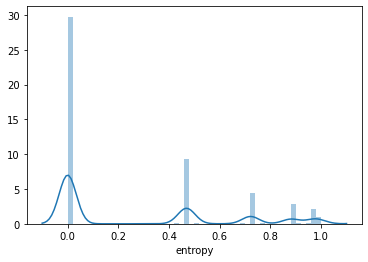

In [371]:
sns.distplot(joined_toxicity_count['entropy'])

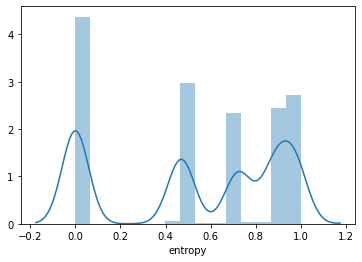

In [372]:
sns.distplot(joined_toxicity_count[joined_toxicity_count['is_toxic']==True]['entropy'])

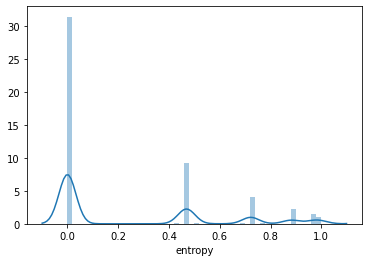

In [374]:
sns.distplot(joined_toxicity_count[joined_toxicity_count['is_toxic']==False]['entropy'])

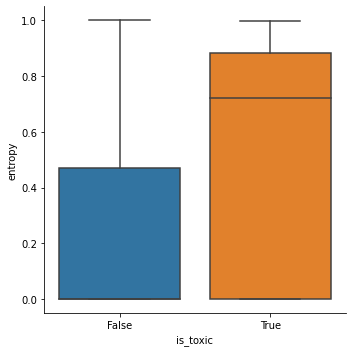

In [373]:
sns.catplot(x="is_toxic", y="entropy", kind="box", data=joined_toxicity_count)

### Personal Attacks

In [375]:
attack_count = pd.DataFrame({"attack_count": attack_annotations.groupby("rev_id")["attack"].apply(lambda c : c.sum())}).reset_index()

In [ ]:
nonattack_count = pd.DataFrame({"nonattack_count": attack_annotations.groupby("rev_id")["attack"].apply(lambda c : (c == 0).sum())}).reset_index()

In [ ]:
joined_attack_count = attack_count.set_index("rev_id").join(nonattack_count.set_index("rev_id")).reset_index()
joined_attack_count['total_count'] = joined_attack_count["attack_count"] + joined_attack_count["nonattack_count"]
joined_attack_count['p_attack'] = joined_attack_count['attack_count']/joined_attack_count['total_count']
joined_attack_count['p_nonattack'] = joined_attack_count['nonattack_count']/joined_attack_count['total_count']
joined_attack_count["entropy"] = -(np.log2(joined_attack_count['p_attack'])*joined_attack_count['p_attack']) - (np.log2(joined_attack_count['p_nonattack'])*joined_attack_count['p_nonattack'])
joined_attack_count["entropy"] = joined_attack_count["entropy"].fillna(0)
joined_attack_count['is_attack'] = joined_attack_count['attack_count']> joined_attack_count['nonattack_count']

In [173]:
joined_attack_count.groupby(['is_attack'])['rev_id'].count().reset_index()

,is_attack,rev_id
0,False,102274
1,True,13590


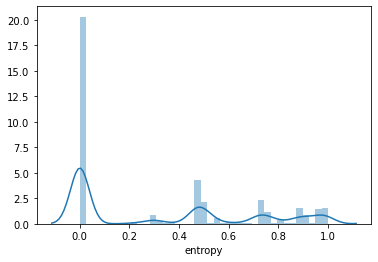

In [176]:
sns.distplot(joined_attack_count['entropy'])

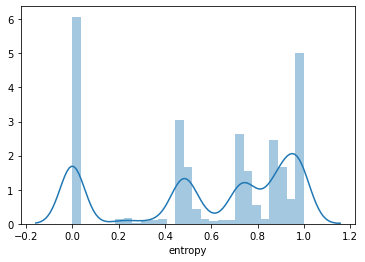

In [177]:
sns.distplot(joined_attack_count[joined_attack_count['is_attack']==True]['entropy'])

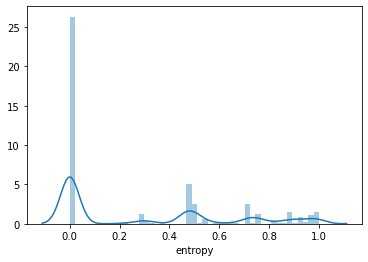

In [175]:
sns.distplot(joined_attack_count[joined_attack_count['is_attack']==False]['entropy'])

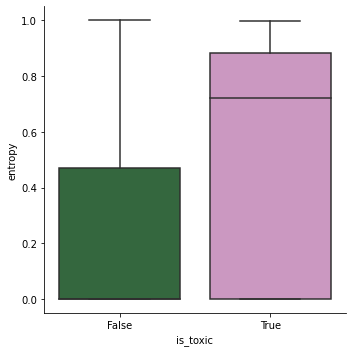

In [333]:
sns.catplot(x="is_toxic", y="entropy", kind="box", data=joined_toxicity_count, palette = 'cubehelix')

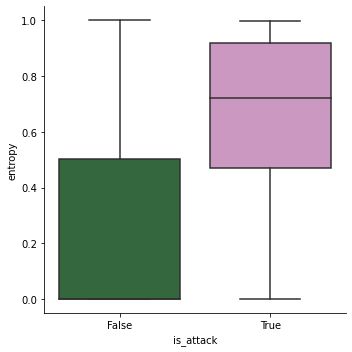

In [334]:
sns.catplot(x="is_attack", y="entropy", kind="box", data=joined_attack_count, palette = 'cubehelix')

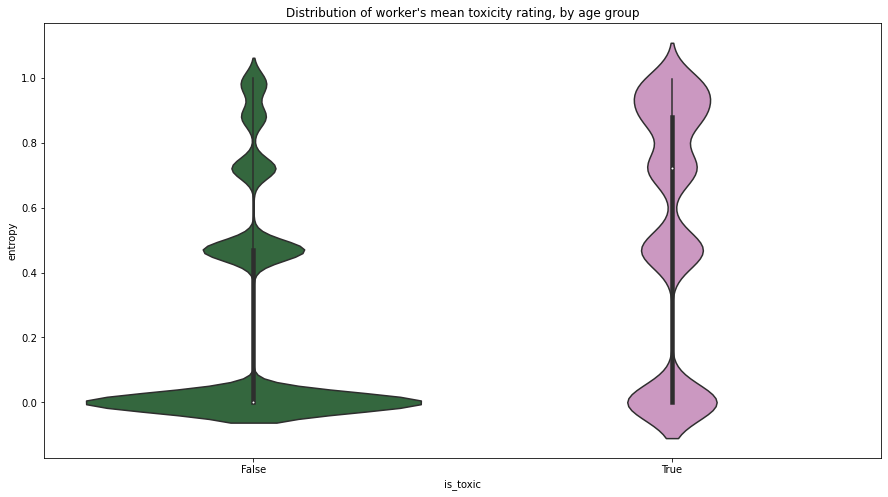

In [332]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of worker's mean toxicity rating, by age group")
sns.violinplot( x="is_toxic", y="entropy", data=joined_toxicity_count, ax=ax , palette = 'cubehelix')

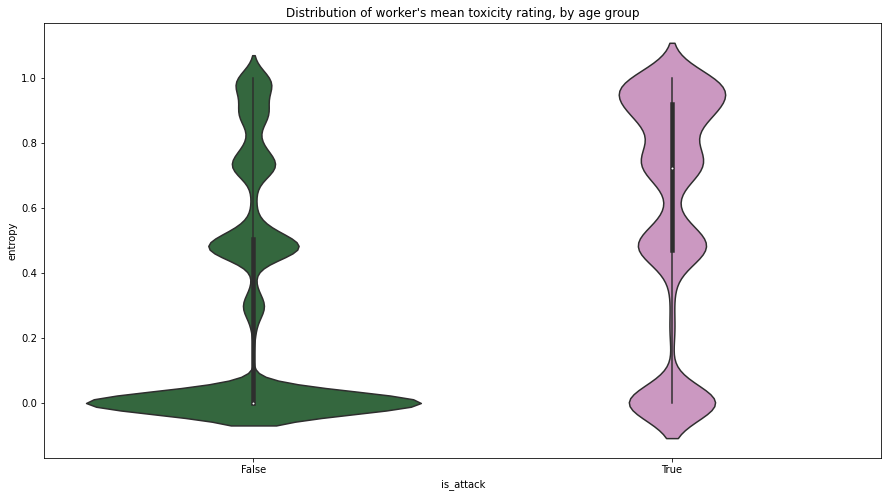

In [331]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of worker's mean toxicity rating, by age group")
sns.violinplot( x="is_attack", y="entropy", data=joined_attack_count, ax=ax, palette = 'cubehelix' )

### Observations  

As can be seen from the violin plots, the mean entropy is higher for the comments with toxicity and attack (both are seen to be around 0.7). A higher mean entropy indicates that there is more disagreement between the labelling of comments that are voted as having toxicity/personal attacks by a majority of the annotators. This indicates that there is more ambiguity between the decision to label comments as toxic/attack. Thus any model trained on this data might not do a very good job in detecting comments with toxicity or personal attacks

In [194]:
toxicity_vs_attack_entropy = joined_attack_count[['rev_id', 'entropy']].merge(joined_toxicity_count[['rev_id', 'entropy']], on = 'rev_id')[['entropy_x', 'entropy_y']]

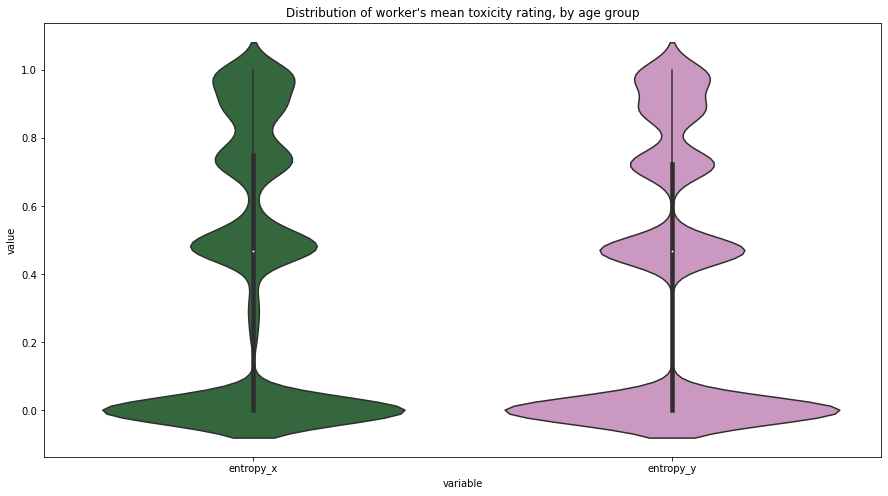

In [330]:
pd.melt(toxicity_vs_attack_entropy)
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of worker's mean toxicity rating, by age group")
sns.violinplot( x="variable", y="value", data=pd.melt(toxicity_vs_attack_entropy), ax=ax, palette = 'cubehelix' )

The overall entropy distribution is very similar for the annotations of personal attack and toxicity.

## Question 2: Explore relationships between worker demographics and labeling behavior

In [238]:
toxicity_worker_demographics = toxicity_worker_demographics.reset_index()
attack_worker_demographics = attack_worker_demographics.reset_index()

In [199]:
toxicity_annotations.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [214]:
toxicity_label_demographics = toxicity_annotations.set_index('worker_id').join(toxicity_worker_demographics.set_index('worker_id'))

In [215]:
toxicity_label_demographics.head()

,rev_id,toxicity,toxicity_score,gender,english_first_language,age_group,education
worker_id,,,,,,,
0,227181.0,0,0.0,male,0.0,30-45,professional
0,1557225.0,0,0.0,male,0.0,30-45,professional
0,1985687.0,0,0.0,male,0.0,30-45,professional
0,8612804.0,0,0.0,male,0.0,30-45,professional
0,11959295.0,0,0.0,male,0.0,30-45,professional


In [307]:
toxicity_gender_labels = toxicity_label_demographics[toxicity_label_demographics['toxicity'] == 1].groupby('gender')['rev_id'].count().reset_index()
toxicity_gender_totals = toxicity_label_demographics.groupby('gender')['rev_id'].count().reset_index()
toxicity_gender_labels['proportion'] = toxicity_gender_labels['rev_id']/toxicity_gender_totals['rev_id']
#toxicity_gender_labels = toxicity_gender_labels.groupby('gender').apply(lambda x: x['rev_id']/sum(x['rev_id'])).reset_index()

In [264]:
toxicity_gender_labels

,gender,rev_id,proportion
0,female,71846,0.157093
1,male,124394,0.139886
2,other,59,0.164804


In [308]:
attack_label_demographics = attack_annotations.set_index('worker_id').join(attack_worker_demographics.set_index('worker_id'))

In [309]:
attack_gender_labels = attack_label_demographics[attack_label_demographics['attack'] == 1].groupby('gender')['rev_id'].count().reset_index()
attack_gender_totals = attack_label_demographics.groupby('gender')['rev_id'].count().reset_index()
attack_gender_labels['proportion'] = attack_gender_labels['rev_id']/attack_gender_totals['rev_id']
#attack_gender_labels = attack_gender_labels.groupby('gender').apply(lambda x: x['rev_id']/sum(x['rev_id'])).reset_index()

In [310]:
attack_gender_labels

,gender,rev_id,proportion
0,female,53486,0.173598
1,male,86856,0.158691
2,other,37,0.445783


In [311]:
toxicity_vs_attack_gender = toxicity_gender_labels.merge(attack_gender_labels, on = 'gender')
toxicity_vs_attack_gender = pd.DataFrame({'gender': toxicity_vs_attack_gender['gender'], 'toxicity':  toxicity_vs_attack_gender['proportion_x'], 'attack': toxicity_vs_attack_gender['proportion_y']})
toxicity_vs_attack_gender = toxicity_vs_attack_gender.set_index('gender').stack().reset_index()

In [312]:
toxicity_vs_attack_gender.columns = ['gender', 'type', 'comments_proportion']

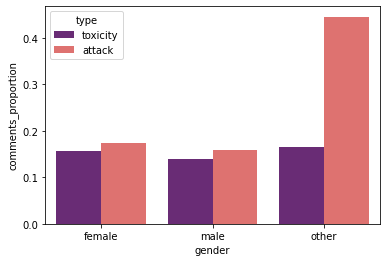

In [327]:
sns.barplot(x = 'gender', y = 'comments_proportion', hue = 'type', palette = 'magma', data = toxicity_vs_attack_gender)

In [314]:
toxicity_age_labels = toxicity_label_demographics[toxicity_label_demographics['toxicity'] == 1].groupby('age_group')['rev_id'].count().reset_index()
toxicity_age_totals = toxicity_label_demographics.groupby('age_group')['rev_id'].count().reset_index()
toxicity_age_labels['proportion'] = toxicity_age_labels['rev_id']/toxicity_age_totals['rev_id']
#toxicity_gender_labels = toxicity_gender_labels.groupby('gender').apply(lambda x: x['rev_id']/sum(x['rev_id'])).reset_index()

In [315]:
toxicity_age_labels

,age_group,rev_id,proportion
0,18-30,99976,0.141173
1,30-45,69997,0.149421
2,45-60,17145,0.166251
3,Over 60,1525,0.156941
4,Under 18,3383,0.120135


In [316]:
attack_age_labels = attack_label_demographics[attack_label_demographics['attack'] == 1].groupby('age_group')['rev_id'].count().reset_index()
attack_age_totals = attack_label_demographics.groupby('age_group')['rev_id'].count().reset_index()
attack_age_labels['proportion'] = attack_age_labels['rev_id']/attack_age_totals['rev_id']

In [317]:
attack_age_labels

,age_group,rev_id,proportion
0,18-30,59083,0.151033
1,30-45,60842,0.170147
2,45-60,16118,0.208477
3,Over 60,1496,0.190792
4,Under 18,1081,0.112875


In [318]:
toxicity_vs_attack_age = toxicity_age_labels.merge(attack_age_labels, on = 'age_group')
toxicity_vs_attack_age = pd.DataFrame({'age_group': toxicity_vs_attack_age['age_group'], 'toxicity':  toxicity_vs_attack_age['proportion_x'], 'attack': toxicity_vs_attack_age['proportion_y']})
toxicity_vs_attack_age = toxicity_vs_attack_age.set_index('age_group').stack().reset_index()

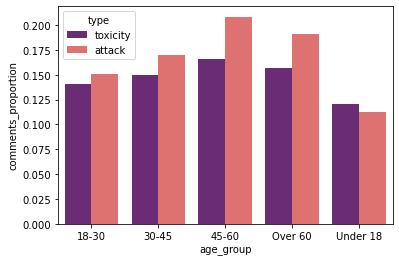

In [326]:
toxicity_vs_attack_age.columns = ['age_group', 'type', 'comments_proportion']
sns.barplot(x = 'age_group', y = 'comments_proportion', hue = 'type', palette = 'magma', data = toxicity_vs_attack_age)

In [336]:
toxicity_education_labels = toxicity_label_demographics[toxicity_label_demographics['toxicity'] == 1].groupby('education')['rev_id'].count().reset_index()
toxicity_education_totals = toxicity_label_demographics.groupby('education')['rev_id'].count().reset_index()
toxicity_education_labels['proportion'] = toxicity_education_labels['rev_id']/toxicity_education_totals['rev_id']

In [337]:
toxicity_education_labels

,education,rev_id,proportion
0,bachelors,80718,0.149419
1,doctorate,1908,0.130837
2,hs,54382,0.142544
3,masters,30281,0.147407
4,none,122,0.131892
5,professional,24106,0.143100
6,some,4782,0.133419


In [338]:
attack_education_labels = attack_label_demographics[attack_label_demographics['attack'] == 1].groupby('education')['rev_id'].count().reset_index()
attack_education_totals = attack_label_demographics.groupby('education')['rev_id'].count().reset_index()
attack_education_labels['proportion'] = attack_education_labels['rev_id']/attack_education_totals['rev_id']

In [339]:
attack_education_labels

,education,rev_id,proportion
0,bachelors,57262,0.165394
1,doctorate,1250,0.164193
2,hs,38406,0.161181
3,masters,25213,0.165614
4,none,6,0.063158
5,professional,15666,0.167827
6,some,2576,0.145331


In [340]:
toxicity_vs_attack_education = toxicity_education_labels.merge(attack_education_labels, on = 'education')
toxicity_vs_attack_education = pd.DataFrame({'education': toxicity_vs_attack_education['education'], 'toxicity':  toxicity_vs_attack_education['proportion_x'], 'attack': toxicity_vs_attack_education['proportion_y']})
toxicity_vs_attack_education = toxicity_vs_attack_education.set_index('education').stack().reset_index()

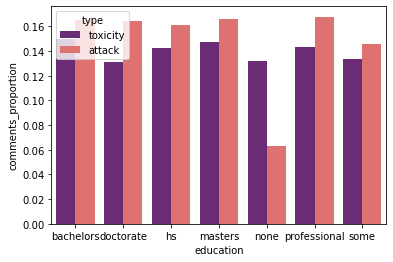

In [341]:
toxicity_vs_attack_education.columns = ['education', 'type', 'comments_proportion']
sns.barplot(x = 'education', y = 'comments_proportion', hue = 'type', palette = 'magma', data = toxicity_vs_attack_education)

In [343]:
toxicity_language_labels = toxicity_label_demographics[toxicity_label_demographics['toxicity'] == 1].groupby('english_first_language')['rev_id'].count().reset_index()
toxicity_language_totals = toxicity_label_demographics.groupby('english_first_language')['rev_id'].count().reset_index()
toxicity_language_labels['proportion'] = toxicity_language_labels['rev_id']/toxicity_language_totals['rev_id']

In [344]:
toxicity_language_labels

,english_first_language,rev_id,proportion
0,0.0,160714,0.144376
1,1.0,35585,0.152207


In [345]:
attack_language_labels = attack_label_demographics[attack_label_demographics['attack'] == 1].groupby('english_first_language')['rev_id'].count().reset_index()
attack_language_totals = attack_label_demographics.groupby('english_first_language')['rev_id'].count().reset_index()
attack_language_labels['proportion'] = attack_language_labels['rev_id']/attack_language_totals['rev_id']

In [347]:
attack_language_labels

,english_first_language,rev_id,proportion
0,0.0,119736,0.161422
1,1.0,20643,0.181469


In [348]:
toxicity_vs_attack_language = toxicity_language_labels.merge(attack_language_labels, on = 'english_first_language')
toxicity_vs_attack_language = pd.DataFrame({'english_first_language': toxicity_vs_attack_language['english_first_language'], 'toxicity':  toxicity_vs_attack_language['proportion_x'], 'attack': toxicity_vs_attack_language['proportion_y']})
toxicity_vs_attack_language = toxicity_vs_attack_language.set_index('english_first_language').stack().reset_index()

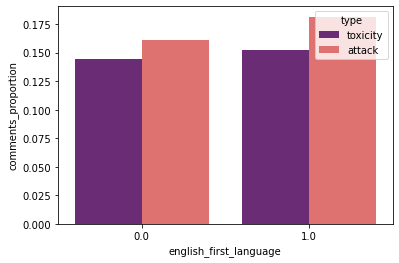

In [349]:
toxicity_vs_attack_language.columns = ['english_first_language', 'type', 'comments_proportion']
sns.barplot(x = 'english_first_language', y = 'comments_proportion', hue = 'type', palette = 'magma', data = toxicity_vs_attack_language)

### Observations  

We observe that there is a similar proportions being tagged as toxic or attack among the different age groups and first language. We see that while the proportion of comments marked as toxic remains similar between different genders, there is an increase in the proportion of comments that workers of 'other' gender label as containing attacks. The possible reason for this could be that the comments annotated for attacks may contain words pertaining to gender or hostile comments for non-binary people.  
We also see that workers with no educational background labelled fewer comments as containing personal attacks.